# Using Random Forest Regression for Data Exploration

In this exercise, we are using machine learning as a tool for data exploration. We are interested in discovering the impact of the other attributes on PM10 dust concentration. One way to investigate this is to check the contribution of each attribute to the prediction accuracy of a learning algorithm. Our algorithm of chocie is [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) due to the interpretability of the resultant predictor. 

In [2]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

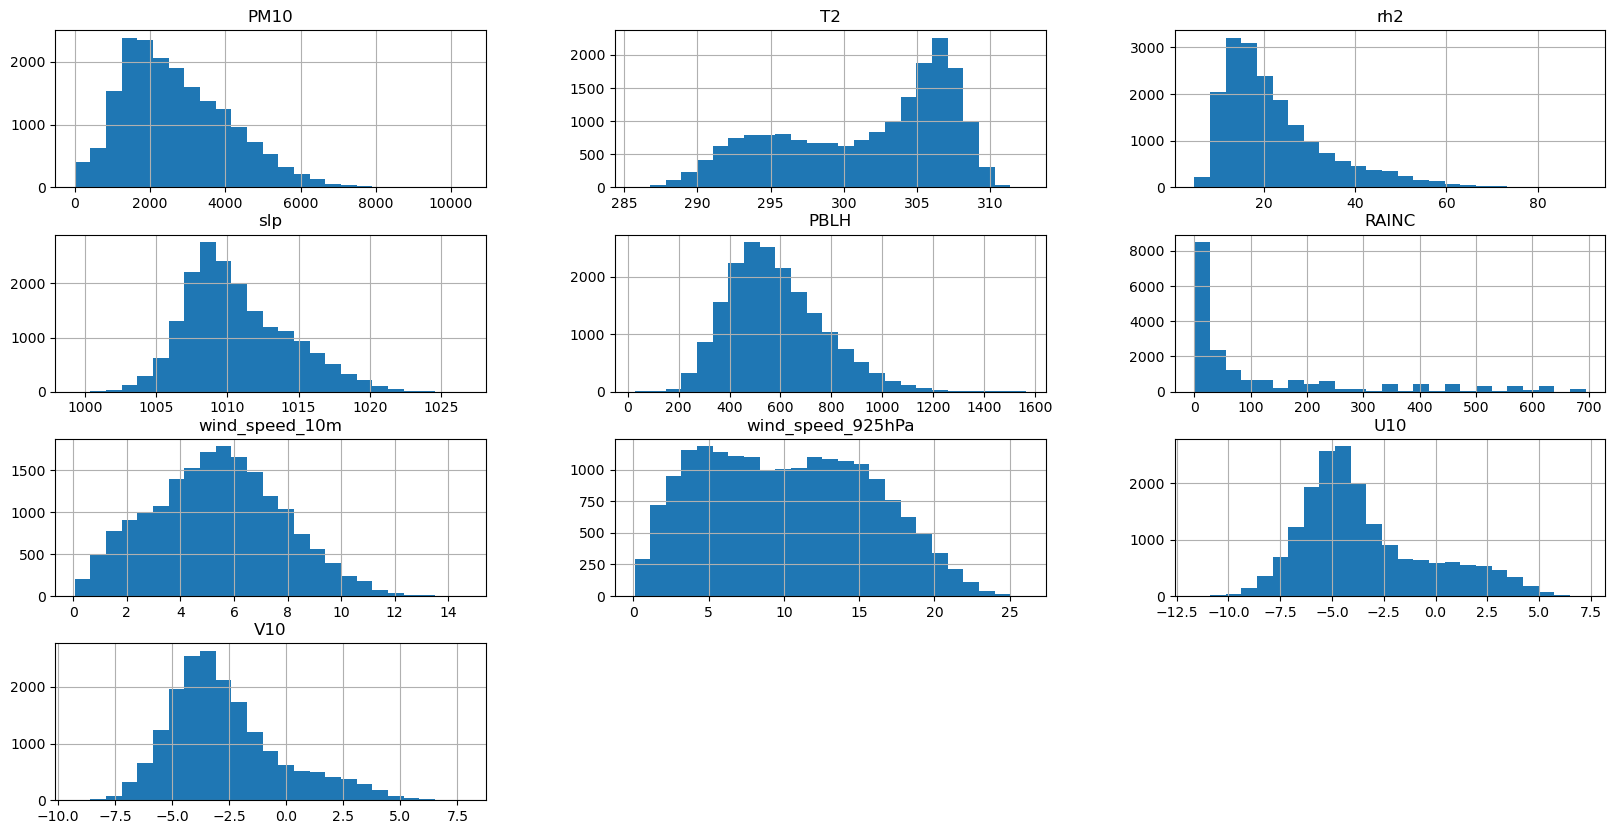

In [8]:
# Loading and visualizing the data
dust_df = pd.read_csv('./saharan_dust_met_vars.csv', index_col='time')

plt.rcParams['figure.figsize'] = [20, 10]
dust_df.hist(bins=25);

The histograms above are showing us the how the features vary across the samples in the dataset. The histogram that stands out the most is `RAINC` due to its strong concentration around a small section of its range. The long tail of the histogram extends to 700 to capture some rare occurences of heavy rain, but most days show little to no precipitation. In order to capture these 'outliers', the majority of the samples are compressed in a small range. To represent the typical days more accurately, we quantize `RAINC` to capture the rain events without the skewing effect of the concentrated distribution.

Using [AMS definitions](https://glossarytest.ametsoc.net/wiki/Rain), and keeping in mind that our data captures a 24 hour range, we use the following conversion on the `RAINC` attribute:
* 0        --> No rain (value `0`)
* (0, 24]  --> Drizzle (value `1`)
* (24,60]  --> Light rain (value `2`)
* (60,182] --> Moderate rain (value `3`)
* 182+     --> Heavy rain (value `4`)

In [10]:
# Converting the RAINC attribute
def cat_precip(row):
        if(row['RAINC'] == 0):
            return 0 #'NR'
        elif((row['RAINC'] > 0) and (row['RAINC'] <= 24)):
            return 1 #'D'
        elif((row['RAINC'] > 24) and (row['RAINC'] <= 60)):
            return 2 #'LR'
        elif((row['RAINC'] > 60) and (row['RAINC'] <= 182)):
            return 3 #'MR'
        elif(row['RAINC'] > 82):
            return 4 #'HR'

dust_df['RAIN'] = dust_df.apply(cat_precip, axis=1)
dust_df = dust_df.drop(columns=["RAINC"])

Another factor in feature engineering is the over-representation of the wind magnitudes. In adition to the wind speeds at two elevations, we have the `U10` and `V10` variables implicitly encoding the same information. We reduce this over-emphasis by converting these two variables into a categorical attribute that only encodes the wind direction in one of the 4 possible values: Southeast (`SE`), Southwest (`SW`), Northeast (`NE`) and Northwest (`NW`).

A common issue for categorical variables is  that they are often not supported by learning algorithms. In order to make this attribute readable for our learnign algorithm, we use a standard practice called [one-hot encoding](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). The idea is to encode a categorical feature as multiple binary features to avoid introducing unintended adjacency biases among them.

In [13]:
# Converting U10 and V10 attributes
def cat_wind_dir(row):
    if((row['U10']>=0) and (row['V10']>=0)):
        return 'SW'
    if((row['U10']>=0) and (row['V10']<0)):
        return 'NW'
    if((row['U10']<0) and (row['V10']>=0)):
        return 'SE'
    else:
        return 'NE'

dust_df['WIND_DIR'] = dust_df.apply(cat_wind_dir, axis=1)
dust_df = dust_df.drop(columns=['U10','V10'])
one_hot = pd.get_dummies(dust_df['WIND_DIR'])
dust_df = dust_df.drop('WIND_DIR', axis=1)
dust_df = dust_df.join(one_hot)

KeyError: 'U10'